# 2d Ising simulations using python_mc_pele

A demonstration of how to use python mc pele to run a simple 2d Ising model. The idea of python_mc_pele is to have a skeleton framework for Markov chain Monte Carlo algorithms/ (or even some non Markov chain ones like Wang Landau)

## Ising variables
The first step is to define our model. A defining aspect of the model we start with, is a set of variables over which the energy is evaluated (which we will call coordinates). For the Ising model, these happen to be discrete variables, which for an up spin would be $1$ and for a down spin would be $-1$. we can map these onto a boolean numpy array and define a function that takes us back to the Ising coordinates. The reason we usually use boolean coordinates is because they take less space when we deal with spins(although not strictly necessary)

In [1]:
%matplotlib inline 
import numpy as np
from matplotlib import pyplot as plt
# an example of variables we would have for an NxN ising model
SPIN_LENGTH = 10

def spin_convert(bool_spin):
    """  a function to convert [True/False] to [1, -1]
    """
    return bool_spin*2-1

## Ising Hamiltonian

now we want to define a hamiltonian on the boolean array variables. The Ising hamiltonian is given by 

/insert latex here/

we can define this as 


In [2]:
from mcpele1.energy import BasePotential

# slightly modified from from
# http://www.physics.rutgers.edu/~haule/681/src_MC/python_codes/wangLand.py

class IsingModel(BasePotential):
    """ The Ising Model in 2d

    """
    def __init__(self, n_x, n_y):
        self.n_x = n_x
        self.n_y = n_y

    def get_energy(self, latt, mcrunner):
        """
        Energy of a 2D periodic Ising lattice
        Takes a boolean array of coordinates 
        and calculates energy for it
        """
        # double counted energy
        energy = 0
        for i in range(self.n_x):
            for j in range(self.n_y):
                spin = spin_convert(latt[i, j])
                w_f = (spin_convert(latt[(i+1) % self.n_x, j])
                       + spin_convert(latt[i, (j+1) % self.n_y])
                       + spin_convert(latt[(i-1) % self.n_x, j])
                       + spin_convert(latt[i, (j-1) % self.n_y]))
                energy += - w_f * spin   # Each neighbor gives energy 1.0
        return int(energy/2.)   # Each par counted twice

## The step
The step to be taken can determine how fast our algorithm converges. while we can go with something like swedsen wang or wolff, we go with a simple single flip move; a class derived from TakeStep should have the displace function that basically flips a random spin

In [3]:
from mcpele1.montecarlo.template import TakeStep
import numpy.random as random

class IsingFlip(TakeStep):
    """ Flips a single ising spin on the lattice at random

    """
    def __init__(self, seed, sizex, sizey):
        random.seed(seed)
        self.seeds = range(np.iinfo(np.int32).max)
        self.sizex = sizex
        self.sizey = sizey
        self.i = 0              # this is ad hoc right now, but check how the seeding should be done

    def displace(self, coords, montecarlo):
        """ flips a single spin
        """
        self.i = self.i+1
        random.seed(self.seeds[self.i])
        # figure out the position of the spin on the lattice
        i_x = random.randint(self.sizex)
        i_y = random.randint(self.sizey)
        coords[i_x, i_y] = not coords[i_x, i_y]

## creating the monte carlo runner
We have our physical system defined along with a step that the system can take. We also have an inbuilt metropolis test in python_mc_pele. which we can now use to create our monte carlo runner

In [4]:
import sys
directory = "/home/praharsh/Dropbox/research/bv-libraries/mcpele1"
sys.path.append(directory)
from mcpele1.montecarlo.mc import MC
from mcpele1.accepttest import MetropolisTest
from mcpele1.action import RecordEnergyTimeSeries



# python raises too many arguments error
# proper fix?
class IsingMetropolisMonteCarlo():
    """ Single flip montecarlo runner for the ising model

    """
    def __init__(self, temperature, N,
                 record_every=10, stepskip=1000, nsteps=1e5):
        random.seed(10)
        initial_coords = random.randint(2,
                                        size=(N, N),
                                        dtype=bool)  # we're starting
                                                     # with a random initial configuration

        # define the monte carlo runner with
        # the potential function , initial coordinates and temperature
        ising_model = IsingModel(N, N)
        self.mc = MC(ising_model, initial_coords, temperature)
        # add the step type
        self.take_step = IsingFlip(10, N, N)
        seeds = range(np.iinfo(np.int32).max)
        # accept test
        self.accept_test = MetropolisTest(seeds)

        # action
        # record_energy
        self.action = RecordEnergyTimeSeries(record_every, stepskip)

        print(initial_coords)
        self.mc.set_take_step(self.take_step)
        self.mc.add_accept_test(self.accept_test)
        self.mc.add_action(self.action)
        self.nsteps = nsteps
    def run(self):
        """ Runs the Monte Carlo simulation
        """
        print(self.nsteps)
        self.mc.run(self.nsteps)

    def get_et_series(self):
        """ gets the array of energies at every iteration
        """
        return np.array(self.action.get_energy_time_series())


# for your syntax checker that may assume the following are global constants
# pylint: disable=C0103

# Ising metropolis methods for the Ising model

ising_mc = IsingMetropolisMonteCarlo(4, 3,
                                     record_every=1, stepskip=0, nsteps=1e4)

[[ True False False]
 [ True False False]
 [False False  True]]


## generating the energy time series for a few temperatures

In [5]:
temps = [0.1, 0.5, 1, 2, 4, 6, 8, 10, 20, 30, 40]
etavl = []
for temp in temps:
    ising_mc = IsingMetropolisMonteCarlo(temp, 4,
                                         record_every=1, stepskip=0, nsteps=1e4)
    ising_mc.run()
    etavl.append(np.average(ising_mc.get_et_series())/4)

[[ True False False  True]
 [False False False False]
 [ True False  True False]
 [False False  True False]]
10000.0
[[ True False False  True]
 [False False False False]
 [ True False  True False]
 [False False  True False]]
10000.0
[[ True False False  True]
 [False False False False]
 [ True False  True False]
 [False False  True False]]
10000.0
[[ True False False  True]
 [False False False False]
 [ True False  True False]
 [False False  True False]]
10000.0
[[ True False False  True]
 [False False False False]
 [ True False  True False]
 [False False  True False]]
10000.0
[[ True False False  True]
 [False False False False]
 [ True False  True False]
 [False False  True False]]
10000.0
[[ True False False  True]
 [False False False False]
 [ True False  True False]
 [False False  True False]]
10000.0
[[ True False False  True]
 [False False False False]
 [ True False  True False]
 [False False  True False]]
10000.0
[[ True False False  True]
 [False False False False]
 [ True Fa

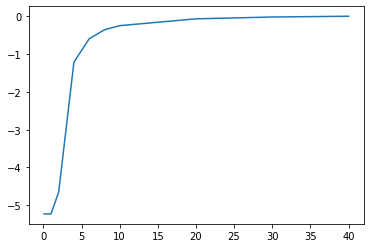

In [6]:
plt.plot(temps, etavl)
plt.show()